# Pre-process CMIP6 ScenarioMIP GHG concentration projections

Concentration data follows [Meinshausen et al., 2020](https://doi.org/10.5194/gmd-13-3571-2020).

## Authors

All notebooks and plots in this repository were generated by the following authors:

- Zebedee Nicholls zebedee.nicholls@climate-energy-college.org
- Jared Lewis jared.lewis@climate-resource.com
- Malte Meinshausen malte.meinshausen@unimelb.edu.au

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import glob
import os.path

import iris
import netcdf_scm.iris_cube_wrappers
import scmdata
import tqdm.autonotebook as tqdman

import utils

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/ar6-wg1-plots-and-processing/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


<IPython.core.display.Javascript object>

In [4]:
OUT_FILE = os.path.join(
    utils.DATA_DIR, "processed", "cmip6-prescribed-concs", "cmip6-prescribed-concs.nc"
)
OUT_FILE

'/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/processed/cmip6-prescribed-concs/cmip6-prescribed-concs.nc'

<IPython.core.display.Javascript object>

In [5]:
SOURCE_DIR = os.path.join(utils.DATA_DIR, "raw", "cmip6-prescribed-concs")

<IPython.core.display.Javascript object>

In [6]:
def read_file(f):
    yearmin = 0
    variable_map = {
        "mole_fraction_of_carbon_dioxide_in_air": "Atmospheric Concentrations|CO2",
        "mole_fraction_of_methane_in_air": "Atmospheric Concentrations|CH4",
        "mole_fraction_of_nitrous_oxide_in_air": "Atmospheric Concentrations|N2O",
    }
    unit_map = {
        "1.e-6": "ppm",
        "1.e-9": "ppb",
    }

    helper = netcdf_scm.iris_cube_wrappers.ScmCube()

    helper.load_data_from_path(f)

    time_slice = helper.cube.extract(
        iris.Constraint(time=lambda t: t[0].year > yearmin)
    )

    for i, txt in enumerate(time_slice.coord("sector").attributes["ids"].split(";")):
        if "Global" in txt:
            global_sector_dim = int(txt.split(":")[0])
            break

    helper_global = time_slice.extract(iris.Constraint(sector=i))

    helper_second = netcdf_scm.iris_cube_wrappers.ScmCube()
    helper_second.cube = helper_global
    time_index, _ = helper._get_openscmdata_time_axis_and_calendar(
        {"World": helper_second}, out_calendar=None
    )

    if "ssp" in f:
        scenario = "ssp{}".format(f.split("ssp")[-1].split("-1-2-1")[0])
    else:
        scenario = "historical"

    out = scmdata.ScmRun(
        data=helper_global.data,
        index=time_index,
        columns={
            "variable": variable_map[helper_global.attributes["variable_id"]],
            "unit": unit_map[str(helper_global.units)],
            "region": "World",
            "scenario": scenario,
            "model": "unspecified",
        },
    )

    return out

<IPython.core.display.Javascript object>

In [7]:
to_read = glob.glob(os.path.join(SOURCE_DIR, "*.nc"))
print(f"{len(to_read)} files to read")
to_read[:3]

30 files to read


['/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/raw/cmip6-prescribed-concs/mole-fraction-of-methane-in-air_input4MIPs_GHGConcentrations_AerChemMIP_UoM-AIM-ssp370-lowNTCF-1-2-1_gr1-GMNHSH_2015-2500.nc',
 '/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/raw/cmip6-prescribed-concs/mole-fraction-of-methane-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-GCAM4-ssp460-1-2-1_gr1-GMNHSH_2015-2500.nc',
 '/data2/ubuntu-znicholls/ar6-wg1-plots-and-processing/src/utils/../../data/raw/cmip6-prescribed-concs/mole-fraction-of-nitrous-oxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc']

<IPython.core.display.Javascript object>

In [8]:
db = scmdata.run_append([read_file(f) for f in tqdman.tqdm(to_read)])
db

  0%|          | 0/30 [00:00<?, ?it/s]

<scmdata.ScmRun (timeseries: 30, timepoints: 2500)>
Time:
	Start: 0001-07-03T12:00:00
	End: 2500-07-02T12:00:00
Meta:
	          model region        scenario unit                        variable
	0   unspecified  World  ssp370-lowNTCF  ppb  Atmospheric Concentrations|CH4
	1   unspecified  World          ssp460  ppb  Atmospheric Concentrations|CH4
	2   unspecified  World          ssp126  ppb  Atmospheric Concentrations|N2O
	3   unspecified  World          ssp585  ppm  Atmospheric Concentrations|CO2
	4   unspecified  World      historical  ppm  Atmospheric Concentrations|CO2
	5   unspecified  World          ssp460  ppb  Atmospheric Concentrations|N2O
	6   unspecified  World          ssp585  ppb  Atmospheric Concentrations|N2O
	7   unspecified  World          ssp370  ppm  Atmospheric Concentrations|CO2
	8   unspecified  World          ssp460  ppm  Atmospheric Concentrations|CO2
	9   unspecified  World          ssp119  ppb  Atmospheric Concentrations|N2O
	10  unspecified  World      histor

<IPython.core.display.Javascript object>

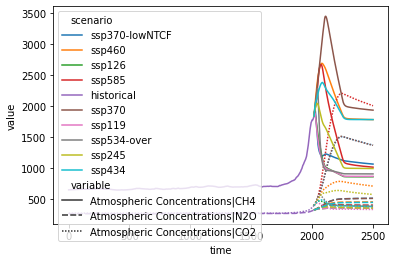

<IPython.core.display.Javascript object>

In [9]:
db.lineplot(time_axis="year", style="variable")

In [10]:
db.to_nc(OUT_FILE, dimensions=("scenario",))

<IPython.core.display.Javascript object>